In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

from psgla import *
from pdla import *
import distributions as pds
import potentials as pot

**Define target densities**\
2D example A: 'Sparse' ground truth signal $u_{\text{true}}$, i.e. point on one of the coordinate axes.
Set $F(u) = \frac{1}{2\sigma^2} \lVert u - u_{\text{true}} \rVert_2^2$ and a sparsity prior $G(u) = \lambda \lVert u \rVert_1$.

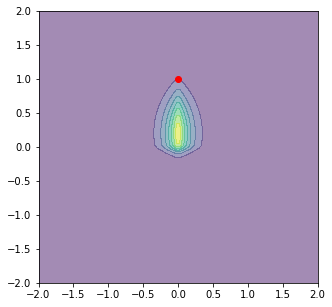

In [2]:
d = 2
u_true = np.array([[0],[1]])
std = 0.4
l1reg = 5
posterior = pds.L2Loss_SparsityReg(d=2, l2shift=u_true, l2scale=std, l1reg=l1reg)
X,Y = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
Z = np.concatenate((np.reshape(X,(1,-1)),np.reshape(Y,(1,-1))), axis=0)
unscaled_dens_vals = posterior.unscaled_pdf(Z)

plt.figure(figsize=(5,5))
unscaled_dens_plot = plt.contourf(X,Y,np.reshape(unscaled_dens_vals,(100,100)),alpha=0.5)
ground_truth = plt.scatter(u_true[0],u_true[1],color='r')

plt.show()

**Sample using PDLA and PSGLA with constant step size**

In [3]:
rng = default_rng()

# what is the gradient Lipschitz constant L in this example? Is the quadratic a good option (since 1/L might be optimal)?
Lf = std**(-2)
tau_psgla = 0.01  *  1/Lf
tau_pdla = 0.1  *  1/(2*Lf)
sigma_pdla =  60 * Lf/4
print('convergence const = {a:.2f};\nConvergence rate factor = {b:.8f}'.format(a=tau_pdla * Lf + sigma_pdla * tau_pdla, b=np.sqrt(tau_pdla/sigma_pdla)))
max_iter = 1000
n_samples = 100
x0 = -1 + 2*rng.uniform(size=(2,n_samples))
y0 = -1 + 2*rng.uniform(size=(2,n_samples))
psgla = PSGLA(max_iter, tau_psgla, x0, pd = posterior)
x_psgla, tau_psgla, sum_tau_psgla = psgla.simulate()

# pdla
pdla = PDLA(max_iter, sigma_pdla, tau_pdla, x0, y0, pd = posterior)
x_pdla, y_pdla = pdla.simulate()

convergence const = 0.80;
Convergence rate factor = 0.00923760


**Compare samples after a fixed (small) number of steps. Is variable step size PSGLA faster?**

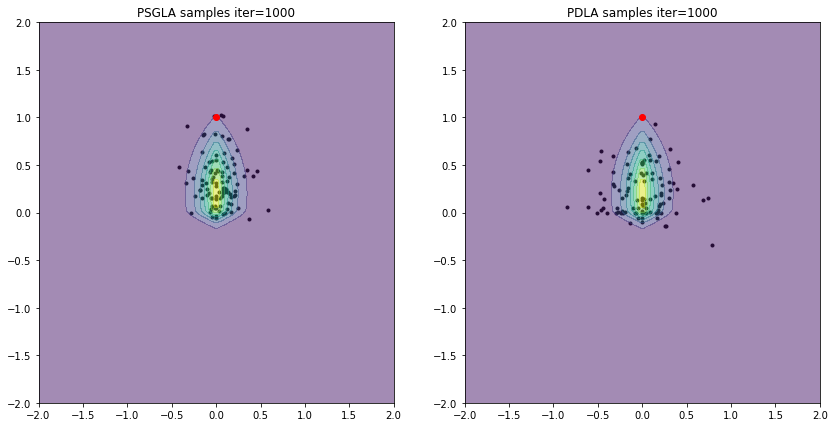

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
scatter_psgla = ax[0].scatter(x_psgla[0,:], x_psgla[1,:], c='k', marker='.')
scatter_pdla = ax[1].scatter(x_pdla[0,:], x_pdla[1,:], c='k', marker='.')

unscaled_dens_plot = ax[0].contourf(X,Y,np.reshape(unscaled_dens_vals,(100,100)),alpha=0.5)
ground_truth = ax[0].scatter(u_true[0],u_true[1],color='r')
ax[0].set_xlim(-2,2)
ax[0].set_ylim(-2,2)
ax[0].set_title('PSGLA samples iter={iter:d}'.format(iter=max_iter))

unscaled_dens_plot = ax[1].contourf(X,Y,np.reshape(unscaled_dens_vals,(100,100)),alpha=0.5)
ground_truth = ax[1].scatter(u_true[0],u_true[1],color='r')
ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2)
ax[1].set_title('PDLA samples iter={iter:d}'.format(iter=max_iter))

plt.show()